In [1]:
import os
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.patheffects as pe
from matplotlib.patches import Patch
from matplotlib.colors import to_rgba
from shapely.geometry import Polygon
from shapely.geometry.base import BaseGeometry
from cartopy.feature import ShapelyFeature
import cartopy.crs as ccrs
from cartes.crs import EuroPP
from traffic.data import airports

c:\Users\kevin\Desktop\Unterlagen\Work\.venv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


aeroway=deicing_pad not in stylesheet, hence ignored
navigationaid=als not in stylesheet, hence ignored
navigationaid=rgl not in stylesheet, hence ignored
navigationaid=txc not in stylesheet, hence ignored
navigationaid=txe not in stylesheet, hence ignored
navigationaid=vasi not in stylesheet, hence ignored


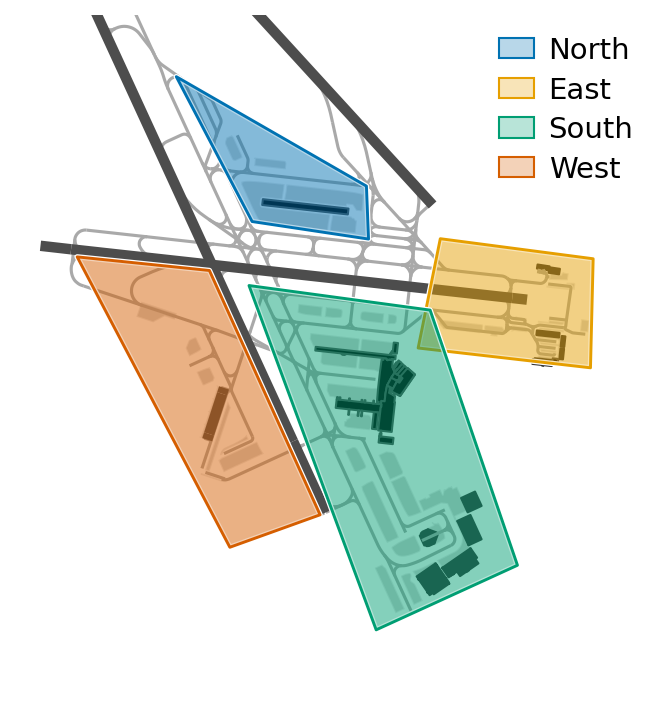

In [2]:
airport_str = "LSZH"

# (lat, lon) -> (lon, lat)
def latlon_to_lonlat(coords):
    return [(lon, lat) for (lat, lon) in coords]

# Iterate over all rings/geoms and yield coordinate arrays
def _collect_xy(geom: BaseGeometry):
    if geom.geom_type == "Polygon":
        xs, ys = geom.exterior.xy
        yield xs, ys
        for ring in geom.interiors:
            xs, ys = ring.xy
            yield xs, ys
    elif geom.geom_type.startswith("Multi"):
        for g in geom.geoms:
            yield from _collect_xy(g)
    else:
        xs, ys = geom.xy
        yield xs, ys

# Set map extent tightly around given geometries with padding (meters)
def set_extent_around(ax, geoms, data_crs, map_crs, pad_m=200):
    Xs, Ys = [], []
    for g in geoms:
        for xs, ys in _collect_xy(g):
            pts = map_crs.transform_points(data_crs, np.asarray(xs), np.asarray(ys))
            Xs.append(pts[:, 0]); Ys.append(pts[:, 1])
    X = np.concatenate(Xs); Y = np.concatenate(Ys)
    ax.set_extent([X.min()-pad_m, X.max()+pad_m, Y.min()-pad_m, Y.max()+pad_m], crs=map_crs)

# ---------------- Coordinates (lat, lon) ----------------
gate_coordinates_North = [
    (47.46222690988436, 8.559511063245429),
    (47.4677137606189,  8.545262706862454),
    (47.46039783236904, 8.550989103256876),
    (47.459544241084316,8.559691422186987),
]
gate_coordinates_East = [
    (47.45860892612085, 8.576476605347214),
    (47.4595824620173,  8.565050900074354),
    (47.454039744220424,8.56344260504518),
    (47.453085179118666,8.576320702453943),
]
gate_coordinates_South = [
    (47.45596248073526, 8.56432081618345),
    (47.457155456631696,8.550783852563612),
    (47.43975178123579, 8.560427038086573),
    (47.44306209954342, 8.570948773913384),
]
gate_coordinates_West = [
    (47.457906230675164,8.547819449164445),
    (47.458555814138954,8.537937541532848),
    (47.443891833614515,8.54946643376971),
    (47.445562620043646,8.55619162090788),
]

# Build polygons (lon, lat)
gate_polygon_North = Polygon(latlon_to_lonlat(gate_coordinates_North))
gate_polygon_East  = Polygon(latlon_to_lonlat(gate_coordinates_East))
gate_polygon_South = Polygon(latlon_to_lonlat(gate_coordinates_South))
gate_polygon_West  = Polygon(latlon_to_lonlat(gate_coordinates_West))

gate_polygons = {
    "North": gate_polygon_North,
    "East" : gate_polygon_East,
    "South": gate_polygon_South,
    "West" : gate_polygon_West,
}

# Plot config
PAD_M, FIGSIZE_INCH, FONTSIZE = 350, (4.6, 4.6), 9
mpl.rcParams.update({
    "figure.dpi": 150, "savefig.dpi": 600, "font.size": FONTSIZE,
    "figure.constrained_layout.use": True, "pdf.fonttype": 42, "ps.fonttype": 42,
    "patch.antialiased": True, "lines.antialiased": True,
})

data_crs = ccrs.PlateCarree()  # interprets (x,y) as (lon,lat)
map_crs  = EuroPP()

features = {n: ShapelyFeature([p], crs=data_crs) for n, p in gate_polygons.items()}

COL = {
    "North": ("#0072B2", to_rgba("#0072B2", 0.28)),
    "East" : ("#E69F00", to_rgba("#E69F00", 0.28)),
    "South": ("#009E73", to_rgba("#009E73", 0.28)),
    "West" : ("#D55E00", to_rgba("#D55E00", 0.28)),
}

# Output folder
out_dir = "Plots"
os.makedirs(out_dir, exist_ok=True)

fig, ax = plt.subplots(1, 1, figsize=FIGSIZE_INCH, subplot_kw=dict(projection=map_crs))

# Optional basemap
if 'airports' in globals() and 'airport_str' in globals():
    airports[airport_str].plot(
        ax, by='aeroway',
        aerodrome=dict(edgecolor="#b8bcc3", facecolor="#f5f6f8", linewidth=0.5, alpha=1.0)
    )

# Tight extent around all four polygons
set_extent_around(ax, list(gate_polygons.values()), data_crs, map_crs, pad_m=PAD_M)

ax.spines.get("geo").set_visible(False)
ax.set_frame_on(False)

halo = [pe.Stroke(linewidth=2.6, foreground="white"), pe.Normal()]
handles = []
for name, feat in features.items():
    edge, face = COL[name]
    ax.add_feature(feat, facecolor=face, edgecolor=edge, linewidth=1.4,
                   zorder=5, path_effects=halo)
    handles.append(Patch(facecolor=face, edgecolor=edge, label=name))

plt.legend(handles=handles, loc='upper right',
           frameon=True, framealpha=0,
           facecolor='white', edgecolor="#e0e0e0",
           borderpad=0.25, labelspacing=0.4, handlelength=1.2, handletextpad=0.5,
           fontsize=14)

fig.savefig(os.path.join(out_dir, "gate_polygons_compact.pdf"),  bbox_inches="tight", pad_inches=0.01)
plt.show()
